In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_excel('../data/SPY.xlsx')
df.columns = df.iloc[5].values
df = df.iloc[6:].iloc[::-1].reset_index(drop=True)
df['Log Return'] = df.PX_LAST.apply(lambda x: np.log(x)).diff()
df.head()

,Date,PX_LAST,Change,% Change,PX_OPEN,Change,% Change,PX_HIGH,Change,% Change,PX_LOW,Change,% Change,Log Return
0,1993-01-29 00:00:00,25.2238,NaN,NaN,25.2417,NaN,NaN,25.2417,NaN,NaN,25.1161,NaN,NaN,NaN
1,1993-02-01 00:00:00,25.4032,NaN,NaN,25.2417,NaN,NaN,25.4032,NaN,NaN,25.2417,NaN,NaN,0.007087
2,1993-02-02 00:00:00,25.457,NaN,NaN,25.3852,NaN,NaN,25.4749,NaN,NaN,25.3314,NaN,NaN,0.002116
3,1993-02-03 00:00:00,25.7261,NaN,NaN,25.4929,NaN,NaN,25.744,NaN,NaN,25.4749,NaN,NaN,0.010515
4,1993-02-04 00:00:00,25.8337,NaN,NaN,25.8158,NaN,NaN,25.8876,NaN,NaN,25.762,NaN,NaN,0.004174


In [302]:
def symmetric(y, beta, q):
    VaR = np.zeros_like(y)
    VaR[0] = np.quantile(y[:300], q)
    
    b1, b2, b3 = beta
    for i in range(1, len(y)):
        VaR[i] = b1 + b2 * VaR[i-1] + b3 * abs(y[i-1])
    
    return VaR

def loss(y, VaR, q):
    dev = y - VaR
    return np.sum(np.maximum(q * dev, (q - 1) * dev))

def sigmoid(x, G):
    """
    mimic indicator function I(x<=0)
    """
    return 1 / (1 + np.exp(G*x))

def derivatives_fbeta(model):
    """
    symmetric:
    asymmetric:
    adaptive:
    igarch:
    """
    if model == 'symmetric':
        pass # -1, - f[t-1]
    elif model == 'asymmetric':
        pass
    elif model == 'adaptive':
        pass
    elif model == 'igarch':
        pass
    else:
        raise ValueError('Wrong Model!')

def get_gradient(y, beta, VaR, q, G):
    """
      d(RQ)/dbeta
    = sum[ (q - sigmoid(y - f(beta))) * d(y - f(beta))/dbeta +
           (y - f(beta)) * d(q - sigmoid(y - f(beta)))/dbeta ]
    """
    gradient = np.zeros_like(beta)
    
    dev = y - VaR
    sigmoid_dev = sigmoid(dev, G)
    for t in range(1, len(y)):
        gradient[0] += (
            (q - sigmoid_dev[t]) * (-1 - beta[1] * gradient[0]) +
            dev[t] * (-1 * (sigmoid_dev[t] * (1 - sigmoid_dev[t]) * (- 1 - beta[1] * gradient[0])))
        )
        
        gradient[1] += (
            (q - sigmoid_dev[t]) * (- beta[1] * gradient[1] - VaR[t-1]) +
            dev[t] * (-1 * (sigmoid_dev[t] * (1 - sigmoid_dev[t]) * (- beta[1] * gradient[1] - VaR[t-1])))
        ) # gradient term of VaR is wrong as VaR[t-1] also contains beta
        
        gradient[2] += (
            (q - sigmoid_dev[t]) * (- abs(y[t-1]) - beta[1] * gradient[2]) +
            dev[t] * (-1 * (sigmoid_dev[t] * (1 - sigmoid_dev[t]) * (- abs(y[t-1] - beta[1] * gradient[2]))))
        )
    
    return gradient

def gradient_descent(y, q=0.05, G=10, learning_rate=0.00000000005, max_iter=1000, tol=1e-10):
    y = np.array(y)
    beta = np.random.uniform(-0.01, .01, 3)
    VaR = symmetric(y, beta, q)
    last = loss(y, VaR, q)
    print(f'[0/{max_iter}] Loss: {last:.4f}')
    
    for i in range(max_iter):
        gradient = get_gradient(y, beta, VaR, q, G)
        beta -= learning_rate * gradient
        VaR = symmetric(y, beta, q)
        current = loss(y, VaR, q)
        print(f'[{i+1}/{max_iter}] Loss: {current:.4f} Beta: {beta}')
        
        if last - current < tol:
            print('Early stopped.')
            print(f'Final Loss: {current:.4f} Beta: {beta}')
            return beta + learning_rate * gradient
        
        last = current
    
    print(f'Finished {max_iter} loop')
    print(f'Final Loss: {current:.4f}')
    return beta

def adam(grad_fn, x0, num_iters=1000, alpha=0.00001, beta1=0.9, beta2=0.999, eps=1e-8):
    # Initialize variables
    m = np.zeros_like(x0)
    v = np.zeros_like(x0)
    x = x0
    
    # Optimization loop
    for t in range(num_iters):
        # Evaluate gradient and compute moving averages of gradient and squared gradient
        grad = grad_fn(x)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * np.square(grad)
        
        # Compute bias-corrected moving averages
        m_hat = m / (1 - beta1 ** (t + 1))
        v_hat = v / (1 - beta2 ** (t + 1))
        
        # Update parameters
        x -= alpha * m_hat / (np.sqrt(v_hat) + eps)
    
    return x

In [303]:
returns = (df['Log Return'].dropna() - df['Log Return'].dropna().mean()).reset_index(drop=True) * 100

In [304]:
beta = np.array([-0.0360569 ,  0.91599347, -0.14813257]) # [-0.03671756  0.9153824  -0.14871019]

In [306]:
beta = gradient_descent(returns)

[0/1000] Loss: 3048.9031
[1/1000] Loss: inf Beta: [-693.12447591   -9.05046267 -316.61989265]
Early stopped.
Final Loss: inf Beta: [-693.12447591   -9.05046267 -316.61989265]


C:\Users\Jasper\AppData\Local\Temp\ipykernel_10988\1392926677.py:7: RuntimeWarning: overflow encountered in double_scalars
  VaR[i] = b1 + b2 * VaR[i-1] + b3 * abs(y[i-1])


0.4847121111846459

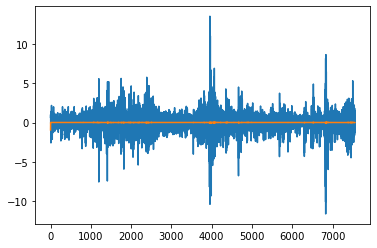

In [285]:
VaR = symmetric(returns, beta, q=0.05)
plt.plot(returns)
plt.plot(VaR)
np.sum(returns <= VaR) / len(returns)